In [13]:
import numpy as np
from scipy import linalg

def GetZ(j, n):
    z = np.array([[1, 0], [0, -1]])
    if j != 1 and j != n:
        Z = np.kron(np.kron(np.identity(2**(j-1)), z), np.identity(2**(n-j)))
    elif j == 1 and j != n:
        Z = np.kron(z, np.identity(2**(n-1)))
    elif j == n and n != 1:
        Z = np.kron(np.identity(2**(n-1)), z)
    else:
        Z = z
    return Z

def GetX(j, n):
    x = np.array([[0, 1], [1, 0]])
    if j != 1 and j != n:
        X = np.kron(np.kron(np.identity(2**(j-1)), x), np.identity(2**(n-j)))
    elif j == 1 and j != n:
        X = np.kron(x, np.identity(2**(n-1)))
    elif j == n and n != 1:
        X = np.kron(np.identity(2**(n-1)), x)
    else:
        X = x
    return X

def GetY(j, n):
    Y = 1j*GetX(j, n).dot(GetZ(j, n))
    return Y

## XY Model

$$ H = J\sum_{j=1}^{n-1} (\frac{1+r}{2}X_jX_{j+1} + \frac{1-r}{2}Y_jY_{j+1}) + h\sum_{j=1}^n Z_j$$

In [14]:
def XY(n, J, r, h):
    H = np.zeros((2**n, 2**n))
    for j in range(1, n):
        H += J*((1+r)/2*GetX(j, n).dot(GetX(j+1, n)) + (1-r)/2*GetY(j, n).dot(GetY(j+1, n)).real.astype('float64'))
    for j in range(1, n+1):
        H += h*GetZ(j, n)
    return H

## XY Model with periodic B.C.s

$$ H = \sum_j \left(J(\frac{1+r}{2} X_j X_{j+1} + \frac{1-r}{2} Y_j Y_{j+1}) + h Z_j \right) $$

where $j$ is taken modulo $n$ for $n$ qubits.

In [3]:
def XYPeriod(n, J, r, h):
    H = np.zeros((2**n, 2**n))
    for j in range(1, n):
        H += J*((1+r)/2*GetX(j, n).dot(GetX(j+1, n)) + (1-r)/2*GetY(j, n).dot(GetY(j+1, n)).real.astype('float64'))
    H += J*((1+r)/2*GetX(n, n).dot(GetX(1, n)) + (1-r)/2*GetY(n, n).dot(GetY(1, n)).real.astype('float64'))
    for j in range(1, n+1):
        H += h*GetZ(j, n)
    return H

## Thermofield Double State

C:\Users\ckmcc\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\ckmcc\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


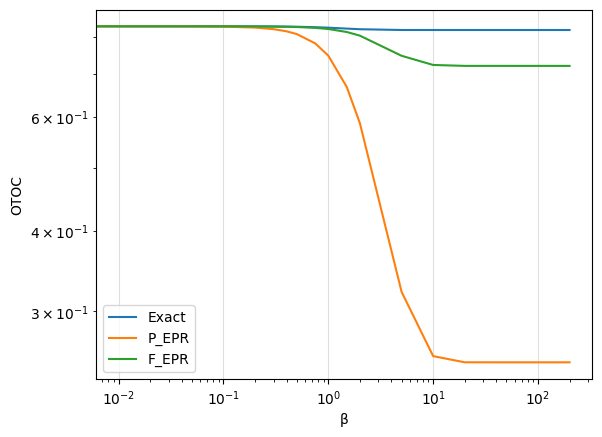

In [6]:
qubits = 3
t = 1
J = 1
r = 0
h = 0
βrange = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 5, 10, 20, 50, 100, 200]
FexactValues = []
P_EPRValues = []
F_EPRValues = []

H = XY(qubits, J, r, h)

for β in βrange:
    ρ = linalg.expm(-β*H)/np.trace(linalg.expm(-β*H))
    Fexact = 0
    
    U = linalg.expm(-1j*t*H)
    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    V = [np.identity(2**qubits), GetX(3, qubits), GetY(3, qubits), GetZ(3, qubits)]
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):
            B = A @ V[l]
            Fexact += np.trace(ρ @ B @ B)
    FexactValues.append(Fexact/16)
    
    epr = np.array([[1/np.sqrt(2)], [0], [0], [1/np.sqrt(2)]])
    # H1 = XY(1, J, r, h)
    # evals1, evecs1 = np.linalg.eig(H1)
    # idx1 = np.argsort(evals1)
    # evals1 = evals1[idx1]
    # evecs1 = evecs1[:, idx1]
    # epr = 0
    
    # for i in range(0, len(evals1)):
    #     epr += np.exp(-0.5*β*evals1[i])*np.kron(evecs1[:, i], evecs1[:, i])/np.sqrt(np.trace(linalg.expm(-β*H1)))
    
    
    H2 = XY(qubits-1, J, r, h)
    
    evals, evecs = np.linalg.eig(H2)
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    TFD = 0
    
    for i in range(0, len(evals)):
        TFD += np.exp(-0.5*β*evals[i])*np.kron(evecs[:, i], evecs[:, i])/np.sqrt(np.trace(linalg.expm(-β*H2)))
    
    initial = np.kron(epr.T, np.kron(TFD, epr.T)).T
    
    SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
    
    for i in range(0, qubits-1):
        initial = np.kron(np.identity(2**(2*qubits-i-1)), np.kron(SWAP, np.identity(2**(1+i)))) @ initial
    
    ψ_f = np.kron(np.identity(2), np.kron(U, np.kron(U.conj(), np.identity(2)))) @ initial
    
    projector = np.kron(np.identity(2**(qubits)), np.kron((epr @ epr.T), np.identity(2**qubits)))
    
    for i in range(0, qubits-1):
        projector = projector @ np.kron(np.identity(2**(qubits+i+1)), np.kron(SWAP, np.identity(2**(qubits-i-1))))
    
    ψ_out = projector @ ψ_f
    
    P_EPR = (ψ_out.conj().T @ ψ_out)[0][0]
    
    P_EPRValues.append(P_EPR)
    
    epr_final = 0.5*(np.kron(np.array([[1, 0], [0, 0]]), np.kron(np.identity(2**(2*qubits)), np.array([[1, 0], [0, 0]]))) + np.kron(np.array([[0, 1], [0, 0]]), np.kron(np.identity(2**(2*qubits)), np.array([[0, 1], [0, 0]]))) + np.kron(np.array([[0, 0], [1, 0]]), np.kron(np.identity(2**(2*qubits)), np.array([[0, 0], [1, 0]]))) + np.kron(np.array([[0, 0], [0, 1]]), np.kron(np.identity(2**(2*qubits)), np.array([[0, 0], [0, 1]]))))
    
    ψ_final = 1/np.sqrt(P_EPR)*epr_final @ ψ_out
    
    F_EPR = (ψ_final.conj().T @ ψ_final)[0][0]
    
    F_EPRValues.append(1/(4*F_EPR))


import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.loglog(βrange, FexactValues, label = 'Exact')
ax.loglog(βrange, P_EPRValues, label = 'P_EPR')
ax.loglog(βrange, F_EPRValues, label = 'F_EPR')
ax.grid(alpha = 0.4)
ax.set(xlabel = 'β', ylabel = 'OTOC')
ax.legend()

## Classical Computation of Operator Spreading

In [4]:
# Set up variables for problem.
qubits = 3
time = 26
tau = 0.2
C =  np.zeros((qubits, time))
X = np.zeros((qubits, time))
Y = np.zeros((qubits, time))

#Set up variables for Hamiltonian
J = 1
r = 0
h = 0

H = XY(qubits, J, r, h)

# eigenvalues, eigenvectors = np.linalg.eig(H)
# idx = np.argsort(eigenvalues)
# eigenvalues = eigenvalues[idx]
# eigenvectors = eigenvectors[:, idx]
# state = eigenvectors[:, 0]

spread = np.zeros((qubits, 3))

W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    
#For each lattice point j, calculates both the OTOC and the Fixed-Node OTOC in time through time increments tau, and stores the result in a matrix. 
for t in range(0, time):
    #Time evolution operator for given time increment t*tau.
    U = linalg.expm(-1j*t*tau*H)
    for j in range(1, qubits+1):
        V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
        spread[j-1][0] = j
        for k in range(0, 4):
            A = U.conj().T @ W[k] @ U
            for l in range(0, 4):              
                #Calculates OTOC functions F and then C for given j and t*tau.
                B = A @ V[l]
                # F = state.conj().T @ B @ B @ state
                F = np.trace(B @ B)/(2**qubits)
                C[j-1][t] += 2-2*F.real

        C[j-1][t] = C[j-1][t]/16

        # if C[j-1][t] > 0.1 and spread[j-1][2] == 0 and t>0:
        #     spread[j-1][1] = (t-1)*tau
        #     spread[j-1][2] = 1
            
        X[j-1][t] = j
        Y[j-1][t] = t*tau

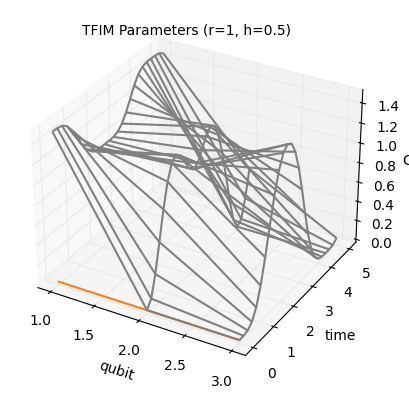

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

#Plots C as a wireframe against j and t (in units of tau).
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_wireframe(X, Y, C, color = 'grey')
ax.plot(spread[:, 0], spread[:, 1], zs = 0, color = 'C1')
# ax.plot([5 for x in Y[4]], Y[4], C[4], color = 'k', linewidth = 3)
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C(t)')
plt.suptitle("TFIM Parameters (r=1, h=0.5)", fontsize = 10, y = 0.85)

ax.xaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)  # Light gray, semi-transparent
ax.yaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)
ax.zaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)

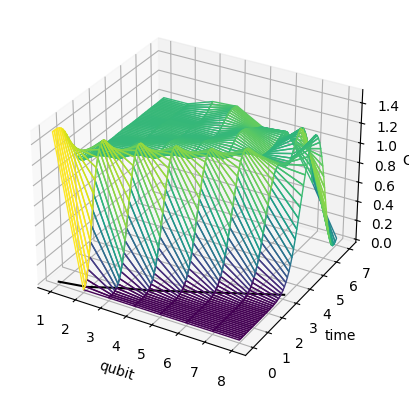

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
norm = plt.Normalize(C.min(), C.max())
colors = cm.viridis(norm(C))
rcount, ccount, _ = colors.shape
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, C, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
ax.plot(spread[:, 0], spread[:, 1], zs = 0, color = 'k')
surf.set_facecolor((0,0,0,0))
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C(t)')
plt.show()

## Butterfly Velocity from Line of Best Fit

In [18]:
# Set up variables for problem.
qubits = 10

#Set up variables for Hamiltonian
J = 1
r = 1.5
h = 1
H = XY(qubits, J, r, h)

# eigenvalues, eigenvectors = np.linalg.eig(H)
# idx = np.argsort(eigenvalues)
# eigenvalues = eigenvalues[idx]
# eigenvectors = eigenvectors[:, idx]
# state = 1/np.sqrt(2)*(eigenvectors[:, 0]+eigenvectors[:, 1])
# state = np.zeros((2**qubits, 1))
# state[0] = 1

spread =  np.zeros((qubits, 2))
W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]

# for m in range(0, 2):
for j in range(1, qubits+1):
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    spreadCheck = np.zeros((3, 1))
    t = 0
    while spreadCheck[2] == 0:
        if spreadCheck[1] == 1:
            t += 0.01
        elif spreadCheck[0] == 1:
            t += 0.1
        else:
            t += 1
        U = linalg.expm(-1j*t*H)
        C = 0
        for k in range(0, 4):
            A = U.conj().T @ W[k] @ U
            for l in range(0, 4):              
                #Calculates OTOC functions F and then C for given j and t*tau.
                B = A @ V[l]
                # if m == 0:
                F = np.trace(B @ B)/(2**qubits)
                # else:
                #     F = state.conj().T @ B @ B @ state
                C += 2-2*F.real

        C = C/16
    
        if C > 0.1:
            if spreadCheck[1] == 1:
                spread[j-1][0] = t-0.01
                spreadCheck[2] = 1
            elif spreadCheck[0] == 1:
                t -= 0.1
                spreadCheck[1] = 1
            else:
                t -= 1
                spreadCheck[0] = 1

# Set up variables for problem.
qubits = 6

H = XY(qubits, J, r, h)

# eigenvalues, eigenvectors = np.linalg.eig(H)
# idx = np.argsort(eigenvalues)
# eigenvalues = eigenvalues[idx]
# eigenvectors = eigenvectors[:, idx]
# state = 1/np.sqrt(2)*(eigenvectors[:, 0]+eigenvectors[:, 1])
# state = np.zeros((2**qubits, 1))
# state[0] = 1

W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]

# for m in range(0, 2):
for j in range(1, qubits+1):
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    spreadCheck = np.zeros((3, 1))
    t = 0
    while spreadCheck[2] == 0:
        if spreadCheck[1] == 1:
            t += 0.01
        elif spreadCheck[0] == 1:
            t += 0.1
        else:
            t += 1
        U = linalg.expm(-1j*t*H)
        C = 0
        for k in range(0, 4):
            A = U.conj().T @ W[k] @ U
            for l in range(0, 4):              
                #Calculates OTOC functions F and then C for given j and t*tau.
                B = A @ V[l]
                # if m == 0:
                F = np.trace(B @ B)/(2**qubits)
                # else:
                #     F = state.conj().T @ B @ B @ state
                C += 2-2*F.real
    
        C = C/16
    
        if C > 0.1:
            if spreadCheck[1] == 1:
                spread[j-1][1] = t-0.01
                spreadCheck[2] = 1
            elif spreadCheck[0] == 1:
                t -= 0.1
                spreadCheck[1] = 1
            else:
                t -= 1
                spreadCheck[0] = 1

2.923976608187136
3.0094582975064488


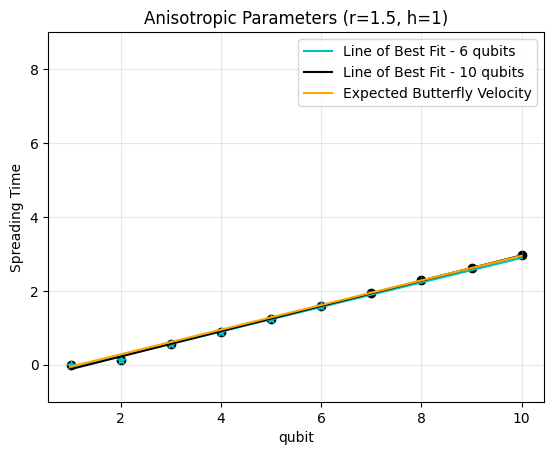

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(1, len(spread)+1)]
y1 = spread[:, 0]
y2 = spread[:qubits, 1]
ax.scatter(x, y1, color = 'k')
ax.scatter(x[:qubits], y2, marker="*", color = 'c')
# ax.scatter(x, y)
ax.grid(alpha = 0.3)
m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x[:qubits], y2, 1)
ax.plot(x, [m2*i+b2 for i in x], color = 'c', label = 'Line of Best Fit - 6 qubits')
ax.plot(x, [m1*i+b1 for i in x], color = 'k', label = 'Line of Best Fit - 10 qubits')
ax.plot(x, [1/3*(i-1)-0.05 for i in x], color = 'orange', label = 'Expected Butterfly Velocity')
ax.set(xlabel = 'qubit', ylabel = 'Spreading Time', title = 'Anisotropic Parameters (r=1.5, h=1)')
ax.set_ylim([-1, 9])
ax.legend()
print(1/m1)
print(1/m2)

In [14]:
print(spread)

[[0.   0.  ]
 [0.12 0.  ]
 [0.56 0.  ]
 [0.88 0.  ]
 [1.24 0.  ]]


## Determining $C_{\text{spread}}$

In [18]:
#Function to calculate the group velocity for given momentum x and Hamiltonian parameters r and h (J=1).
def GroupVelocity(x, r, h):
    return -2*(np.sin(x)*(h-np.cos(x))+r**2*np.sin(x)*np.cos(x))/(np.sqrt((h-np.cos(x))**2+r**2*np.sin(x)**2))

def ButterflyVelocity(r, h):
    k = [i*0.01*np.pi-np.pi for i in range(0, 200)]
    vg = []
    for x in k:
        vg.append(GroupVelocity(x, r, h))
    return max(vg)

In [21]:
def NumericButterflyVelocity(qubits, r, h, Cspread):
    #Creates the Hamiltonian matrix with the given parameter values.
    J = 1
    H = XY(qubits, J, r, h)
    
    # #Used to calculate the ground state eigenvctor for investigating zero temp instead of infinite temp state.
    # eigenvalues, eigenvectors = np.linalg.eig(H)
    # idx = np.argsort(eigenvalues)
    # eigenvalues = eigenvalues[idx]
    # eigenvectors = eigenvectors[:, idx]
    # state = eigenvectors[:, 0]
    
    #Creates an array to store the spreading time values for each qubit.
    spread =  np.zeros((qubits, 2))
    
    #Sets up the W matrices on the first qubit, which are then averaged over to find the operator-averaged OTOC.
    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    
    #For each qubit j, the spreading time is calculated via t_spread = min_t{C_j(t)>0.1} up to 0.01 precision.
    for j in range(1, qubits+1):
    
        #Sets up the V matrices on qubit j, which are then averaged over to find the operator-averaged OTOC.
        V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    
        #spreadCheck is an array used to find the spreading time to increasing orders of precision efficiently.
        spreadCheck = np.zeros((3, 1))

        #Program will increment in time steps of 1 until the spreading time has been found to order 1, then takes a step back and 
        #increments in time steps of 0.1 until the spreading time has been found to order 0.1, then takes a step back and increments
        #in time steps of 0.01 until the spreading time has been found to order 0.01.
        t = 0
        while spreadCheck[2] == 0:
    
            #Increments the time based on which precision level has been reached.
            if spreadCheck[1] == 1:
                t += 0.01
            elif spreadCheck[0] == 1:
                t += 0.1
            else:
                t += 1
    
            #Time evolution operator for given time t.
            U = linalg.expm(-1j*t*H)
    
            
            C = 0
            #For each Pauli matrix in V and W the commutator C = 2-2*Re(F) is calculated and added together.
            for k in range(0, 4):

                #F = U^dagger @ W @ U @ V @ U^dagger @ W @ U @ V is calculated in a computationally efficient manner.
                A = U.conj().T @ W[k] @ U
                for l in range(0, 4):              
                    #Calculates OTOC functions F and then C for given j and t*tau.
                    B = A @ V[l]
                    F = B @ B
                    
                    #For zero temp state the OTOC is calculated using the ground state calculated earlier; for infinite temp state the OTOC is
                    #calculated via the trace of F, appropriately normalised.
                    F = np.trace(F)/(2**qubits)
                    # F = state.conj().T @ F @ state
    
                    #Commutator is calculated from the OTOC F.
                    C += 2-2*F.real
    
            #Commutator is appropriately normalised to find the operator-averaged commutator.
            C = C/16

            #Checks if the spreading time has been reached to the appropriate level of precision, and then updates the precision level if so.
            if C > Cspread:
                if spreadCheck[1] == 1:
                    spread[j-1][0] = t-0.01
                    spreadCheck[2] = 1
                elif spreadCheck[0] == 1:
                    t -= 0.1
                    spreadCheck[1] = 1
                else:
                    t -= 1
                    spreadCheck[0] = 1
                    
    
    x = [i for i in range(2, len(spread)+1)]
    y = spread[1:, 0]
    
    #Calculates and plots the line of best fit for the spreading times.
    m, b = np.polyfit(x, y, 1)
    return 1/m

In [ ]:
NumericButterflyVelocity(qubits, 1.0, 0.0001, 0.05)

In [46]:
# Set up number of qubits for model.
qubits = 5
Cspread = 0.1

#Inputs the parameters for the Hamiltonian.
rRange = 11
hRange = 5
for x in range(0, rRange):
    r = x/5+0.0001
    for y in range(0, hRange):
        h = y/2+0.0001
        exactvB = ButterflyVelocity(r, h)
        numericvB = NumericButterflyVelocity(qubits, r, h, c)
        print("r = " + str(r) + ", h = " + str(h) + ": Exact vB = " + str(exactvB) + ", Numerical vB = " + str(numericvB) + ", Difference = " + str(abs(exactvB - numericvB)))

r = 0.0001, h = 0.0001: Exact vB = 1.9990030445576974, Numerical vB = 1.9230769230769234, Difference = 0.07592612148077404
r = 0.0001, h = 0.5001: Exact vB = 1.9999999600159963, Numerical vB = 1.9230769230769234, Difference = 0.07692303693907299
r = 0.0001, h = 1.0001: Exact vB = 1.999999990002, Numerical vB = 1.9230769230769234, Difference = 0.07692306692507667
r = 0.0001, h = 1.5001: Exact vB = 1.999999995556148, Numerical vB = 1.9230769230769234, Difference = 0.0769230724792247
r = 0.0001, h = 2.0001: Exact vB = 1.99999999750025, Numerical vB = 1.9230769230769234, Difference = 0.07692307442332669
r = 0.2001, h = 0.0001: Exact vB = 1.5993991726539487, Numerical vB = 1.8552875695732838, Difference = 0.25588839691933507
r = 0.2001, h = 0.5001: Exact vB = 1.8760667594834801, Numerical vB = 1.8691588785046735, Difference = 0.006907880978806569
r = 0.2001, h = 1.0001: Exact vB = 1.9611311773488675, Numerical vB = 1.8796992481203014, Difference = 0.08143192922856612
r = 0.2001, h = 1.5001:

KeyboardInterrupt: 

## Group Velocity Graphs

C:\Users\ckmcc\AppData\Local\Temp\ipykernel_18640\897598389.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return -2*(np.sin(x)*(h-np.cos(x))+r**2*np.sin(x)*np.cos(x))/(np.sqrt((h-np.cos(x))**2+r**2*np.sin(x)**2))


(-4.0, 4.0)

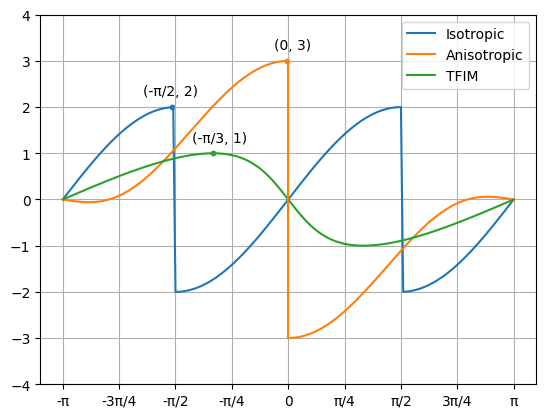

In [16]:
def GroupVelocity(x, r, h):
    return -2*(np.sin(x)*(h-np.cos(x))+r**2*np.sin(x)*np.cos(x))/(np.sqrt((h-np.cos(x))**2+r**2*np.sin(x)**2))

x = [i*0.01*np.pi-np.pi for i in range(0, 201)]
y1 = [2*np.sin(i)*(np.sign(np.cos(i))) for i in x]
y2 = [GroupVelocity(i, 1.5, 1) for i in x]
y3 = [GroupVelocity(i, 1, 0.5) for i in x]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, y1, label = 'Isotropic')
ax.plot(x, y2, label = 'Anisotropic')
ax.plot(x, y3, label = 'TFIM')
ax.plot([0, 0], [3, -3], color = 'C1')

ax.scatter(-np.pi/2-0.042, 2, color = 'C0', sizes = [10])
ax.scatter(-0.02, 3, color = 'C1', sizes = [10])
ax.scatter(-np.pi/3, 1, color = 'C2', sizes = [10])

theta = np.arange(-np.pi, np.pi+np.pi/4, step=(np.pi / 4))
plt.xticks(theta, ['-π', '-3π/4', '-π/2', '-π/4', '0', 'π/4', 'π/2', '3π/4', 'π'])

ax.annotate("(-π/2, 2)", (-np.pi/2-0.45, 2.25))
ax.annotate("(0, 3)", (-0.2, 3.25))
ax.annotate("(-π/3, 1)", (-np.pi/3-0.3, 1.25))
ax.grid()
ax.legend()
axes = plt.gca()
axes.set_ylim([-4, 4])

## Quantum Circuit for YKY Protocol

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeOsaka

def YKYQuantum(totalQubits, U, UConj, target, qr):
    cr = ClassicalRegister(2, 'c0')
    cr2 = ClassicalRegister(2, 'c1')
    YKY = QuantumCircuit(qr, cr, cr2)

    YKY.h(qr[0])
    YKY.cx(qr[0], qr[1])
    YKY.h(qr[-2])
    YKY.cx(qr[-2], qr[-1])
    for i in range(2, int(totalQubits/2)):
        YKY.h(qr[i])
        YKY.cx(qr[i], qr[-(i+1)])

    YKY.append(U, [qr[i] for i in range(1, int(totalQubits/2))])
    # YKY.append(U.inverse().reverse_ops(), [qr[-i] for i in range(2, int(totalQubits/2)+1)])
    YKY.append(UConj, [qr[-i] for i in range(2, int(totalQubits/2)+1)])

    YKY.cx(qr[target], qr[-1*(target+1)])
    YKY.h(qr[target])

    YKY.measure([target, -1*(target+1)], cr)

    YKY.cx(qr[0], qr[-1])
    YKY.h(qr[0])

    YKY.measure([0, -1], cr2)

    return YKY

In [9]:
def LayerA(g, n):
    L1 = 1
    for j in range(2, n+1):
        if j%2 == 0:
            L1 = np.kron(L1, g)
    if n%2 == 1:
        L1 = np.kron(L1, np.identity(2))
    return L1

In [10]:
def LayerB(g, n):
    L1 = np.identity(2)
    for j in range(3, n+1):
        if j%2 == 1:
            L1 = np.kron(L1, g)
    if n%2 == 0:
        L1 = np.kron(L1, np.identity(2))
    return L1

In [11]:
def E(G, l, n):
    W = np.identity(2**n)
    for j in range(0, l):
        if j%2 == 0:
            W = W @ LayerA(G[:, :, j], n)
        else:
            W = W @ LayerB(G[:, :, j], n)
    return W

In [31]:
t = 2.8
U = linalg.expm(-1j*H*t)

print(np.trace(U.conj().T @ E(gatesqubit5[:, :, :, 19], 8, 5)).real/2**5)

0.9991729986528766


## Quantum RTR Wireframe

In [5]:
# %matplotlib ipympl
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeOsaka

import scipy.io

mat_contents = scipy.io.loadmat('Hamiltonians6Param1.mat')
my_tensor = mat_contents['x']
print(my_tensor.shape)

# backend = AerSimulator.from_backend(FakeOsaka())
backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# backend = service.least_busy(operational = True, simulator = False)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Set up variables for problem.
qubits = 6
time = 6
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
C = np.zeros((qubits, 10*time))
Cexact = np.zeros((qubits, 10*time))
X = np.zeros((qubits, 10*time))
Y = np.zeros((qubits, 10*time))

#Set up variables for Hamiltonian
J = 1
r = 0
h = 0

H = XY(qubits, J, r, h)

with Session(backend = backend) as session:
    sampler = Sampler(mode=session)
    for l in range(1, 10*time+1):
        t = l/20
    
        #Time evolution operator for given time increment t*tau.
        # UMatrix = linalg.expm(-1j*H*t)
        
        # UExact = UnitaryGate(UMatrix, label='U')
    
        # UExactDag = UnitaryGate(UMatrix.conj())
        
        U = QuantumCircuit(qubits)
        UConj = QuantumCircuit(qubits)
        for i in range(0, 12):
            if (11-i)%2 == 0:
                for j in range(0, int(qubits/2)):
                    U.append(UnitaryGate(my_tensor[:, :, 11-i, l-1]), [2*j, 2*j+1])
                    UConj.append(UnitaryGate(my_tensor[:, :, 11-i, l-1].conj()), [2*j, 2*j+1])
            else:
                for j in range(0, int(qubits/2)-1):
                    U.append(UnitaryGate(my_tensor[:, :, 11-i, l-1]), [2*j+1, 2*j+2])
                    UConj.append(UnitaryGate(my_tensor[:, :, 11-i, l-1].conj()), [2*j+1, 2*j+2])
    
        # U.append(UnitaryGate(E(my_tensor[:, :, :, int(10*t)-1], 12, qubits)), [i for i in range(0, qubits)])
                    
        OTOC = []
        for j in range(1, qubits+1):
    
            # OTOC1 = YKYQuantum(2*(qubits+1), UExact, j, OTOC_qr)
            OTOC2 = YKYQuantum(2*(qubits+1), U, UConj, j, OTOC_qr)
        
            isa_circuit = []
            # isa_circuit.append(pass_manager.run(OTOC1))
            isa_circuit.append(pass_manager.run(OTOC2))
        
            shots = 10000
    
            result = sampler.run(isa_circuit, shots = shots).result()
            
            # counts1 = result[0].data
            counts2 = result[0].data
            # prob1 = 0
            prob2 = 0
            # fid1 = 0
            fid2 = 0
            for i in range(0, shots):
                # if counts1.c0.array[i] == 0:
                #     prob1 += 1
                #     if counts1.c1.array[i] == 0:
                #         fid1 += 1
                if counts2.c0.array[i] == 0:
                    prob2 += 1
                    if counts2.c1.array[i] == 0:
                        fid2 += 1

            # fid1 = fid1/prob1
            # fid1 = 1/(4*fid1)
            # prob1 = prob1/shots
        
            fid2 = fid2/prob2
            fid2 = 1/(4*fid2)
            prob2 = prob2/shots
        
            # C[0][k][j-1][l-1]= 2-2*fid1
            C[j-1][l-1] = 2-2*fid2
            X[j-1][l-1] = j
            Y[j-1][l-1] = t

session.close()

# W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
# for m in range(1, 10*time+1):
#     t = m/20
#     for j in range(1, qubits+1):
#         V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    
#         U = linalg.expm(-1j*H*t)
#         for k in range(0, 4):
#             A = U.conj().T @ W[k] @ U
#             for l in range(0, 4):              
#                 #Calculates OTOC functions F and then C for given j and t*tau.
#                 B = A @ V[l]
#                 F = np.trace(B @ B)/(2**qubits)
#                 Cexact[j-1][m-1] += 2-2*F.real
    
#         Cexact[j-1][m-1] = Cexact[j-1][m-1]/16
#         X[j-1][m-1] = j
#         Y[j-1][m-1] = t

KeyboardInterrupt: 

[Text(0.5, 0, 'qubit'), Text(0.5, 0.5, 'time'), Text(0.5, 0, 'C(t)')]

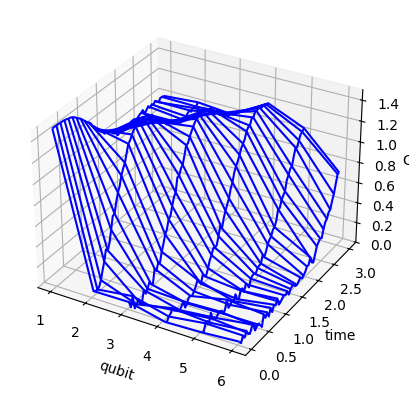

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# ax.plot_wireframe(X, Y, Cexact, color = 'blue')
ax.plot_wireframe(X, Y, C, color = 'blue')
axes = plt.gca()
axes.set_zlim([0, 1.5])
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C(t)')

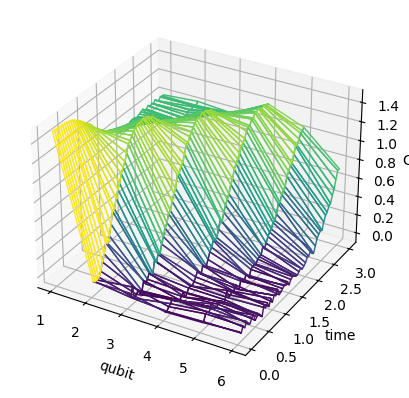

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
norm = plt.Normalize(C.min(), C.max())
colors = cm.viridis(norm(C))
rcount, ccount, _ = colors.shape
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, C, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C(t)')
plt.show()

In [21]:
import scipy.io

mat_contents = scipy.io.loadmat('Hamiltonians2.mat')
G = mat_contents['x']

ECR = 1/np.sqrt(2)*np.array([[0, 1, 0, 1j], [1, 0, -1j, 0], [0, 1j, 0, 1], [-1j, 0, 1, 0]])

U = np.kron(G[:, :, 4], G[:, :, 5])@ECR@np.kron(G[:, :, 2], G[:, :, 3])@ECR@np.kron(G[:, :, 0], G[:, :, 1]);

qubits = 2
J = 1
r = 0
h = 0
t = 1
H = XY(qubits, J, r, h)

for j in range(1, 3):
    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    
    Cexact = 0
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact += 2-2*F.real
    
    Cexact = Cexact/16
    print("Exact: ", Cexact)

Exact:  1.2493159899676327
Exact:  1.1654629033417132


In [78]:
# %matplotlib ipympl
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeKyiv

import scipy.io

mat_contents = scipy.io.loadmat('Hamiltonians4.mat')
my_tensor = mat_contents['x']

# backend = AerSimulator.from_backend(FakeKyiv())
backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# backend = service.backend("ibm_kyiv")
# backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

qubits = 0
qr = QuantumRegister(2*(qubits+1), 'q')

YKY = QuantumCircuit(qr)

# YKY.h(qr[0])
# YKY.cx(qr[0], qr[1])

# YKY.rz(np.pi/2, qr[0])
# YKY.rz(-np.pi, qr[1])
# YKY.sx(qr[0])
# YKY.sx(qr[1])
# YKY.rz(-np.pi, qr[1])
# YKY.ecr(qr[0], qr[1])
# YKY.x(qr[0])

YKY.rz(-np.pi/2, 0)
YKY.rz(np.pi/2, 1)
YKY.sx(0)
YKY.sx(1)
YKY.rz(-2.9909438708147853, 0)
YKY.rz(-2.6838128022176715, 1)
YKY.sx(1)
YKY.rz(np.pi/2, 1)
YKY.ecr(0, 1)
YKY.rz(-1.4201475440198885, 0)
YKY.rz(np.pi/2, 1)
YKY.sx(0)
YKY.sx(1)
YKY.rz(np.pi/2, 0)
YKY.rz(2.6838128022176733, 1)

print(YKY.draw())

# YKY.measure_all()

# U = QuantumCircuit(qubits)
# UConj = QuantumCircuit(qubits)

# U, UConj = NewRTRCalib(U, UConj, my_tensor)

# print(U.draw())

# YKY = pass_manager.run(U)

# YKY = pass_manager.run(YKY)

# shots = 10000
# # with Session(backend = backend) as session:
# sampler = Sampler(backend)
# result = sampler.run([YKY], shots = shots).result()

# print(result[0].data.meas.get_counts())

     ┌──────────┐┌────┐┌─────────────┐                 ┌──────┐┌─────────────┐»
q_0: ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-2.9909) ├─────────────────┤0     ├┤ Rz(-1.4201) ├»
     ├─────────┬┘├────┤├─────────────┤┌────┐┌─────────┐│  Ecr │└─┬─────────┬─┘»
q_1: ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-2.6838) ├┤ √X ├┤ Rz(π/2) ├┤1     ├──┤ Rz(π/2) ├──»
     └─────────┘ └────┘└─────────────┘└────┘└─────────┘└──────┘  └─────────┘  »
«     ┌────┐ ┌─────────┐  
«q_0: ┤ √X ├─┤ Rz(π/2) ├──
«     ├────┤┌┴─────────┴─┐
«q_1: ┤ √X ├┤ Rz(2.6838) ├
«     └────┘└────────────┘


## Single Quantum RTR

[Text(0.5, 0, 'j'), Text(0, 0.5, 'F_j(1)')]

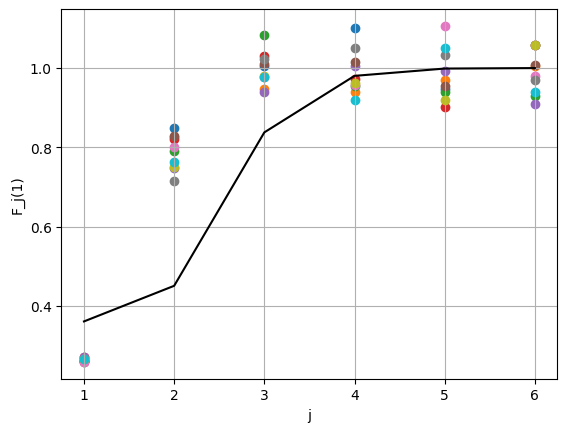

In [101]:
# %matplotlib ipympl
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeTorino

import scipy.io

# backend = AerSimulator.from_backend(FakeTorino())
backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="8c2dfffc2ea9f651c6ab08ef76e09bcde67652ec904ea1f5b7f2fbe3a296648712762bce46e8044b50882a2388712dba15f5ce94079f5267769c21b0367764b5")
# backend = service.backend("ibm_brisbane")
# backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Set up variables for problem.
qubits = 6
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
# CF = np.zeros((qubits, 20))
# Cexact = np.zeros((qubits, 20))
# X = np.zeros((qubits, 20))
# Y = np.zeros((qubits, 20))

#Set up variables for Hamiltonian
J = 1
r = 0
h = 0
t = 1
# target = 1

H = XY(qubits, J, r, h)

# W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
# for m in range(1, 21):
#     t = m/10
#     U = linalg.expm(-1j*H*t)
#     for j in range(1, qubits+1):
#         V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
#         Cexact[j-1][m-1] = 0
#         for k in range(0, 4):
#             A = U.conj().T @ W[k] @ U
#             for l in range(0, 4):              
#                 #Calculates OTOC functions F and then C for given j and t*tau.
#                 B = A @ V[l]
#                 F = np.trace(B @ B)/(2**qubits)
#                 Cexact[j-1][m-1] += 2-2*F.real

#         Cexact[j-1][m-1] = Cexact[j-1][m-1]/16
#         X[j-1][m-1] = j
#         Y[j-1][m-1] = t

mat_contents = scipy.io.loadmat('Hamiltonians6Param1.mat')
my_tensor = mat_contents['x']

m = 12
# for l in range(1, 21):
#     t = l/10
U = QuantumCircuit(qubits)
UConj = QuantumCircuit(qubits)
# UCalib = QuantumCircuit(qubits)
# UConjCalib = QuantumCircuit(qubits)
for i in range(0, m):
    if (m-1-i)%2 == 0:
        for j in range(0, int(qubits/2)):
            U.append(UnitaryGate(my_tensor[:, :, m-1-i, 9]), [2*j, 2*j+1])
            UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, 9].conj()), [2*j, 2*j+1])
    else:
        for j in range(0, int(qubits/2)-1):
            U.append(UnitaryGate(my_tensor[:, :, m-1-i, 9]), [2*j+1, 2*j+2])
            UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, 9].conj()), [2*j+1, 2*j+2])

# UMatrix = linalg.expm(-1j*H*t)

# U = UnitaryGate(UMatrix, label='U')

# UConj = UnitaryGate(UMatrix.conj())

# U, UConj = NewRTR(U, UConj, my_tensor)

# U, UConj = NewRTRTorino(U, UConj, my_tensor)

# UCalib, UConjCalib = NewRTRCalib(UCalib, UConjCalib, my_tensor)

isa_circuit = []
for j in range(1, qubits+1):

    # OTOCcalib = YKYQuantum(2*(qubits+1), UCalib, UConjCalib, j, OTOC_qr)
    # isa_circuit.append(pass_manager.run(OTOCcalib))
    OTOC = YKYQuantum(2*(qubits+1), U, UConj, j, OTOC_qr)
    isa_circuit.append(pass_manager.run(OTOC))    

# job = service.job('cv2z4qthdzz00080mtk0')
# result = job.result()

# isa_circuit = [pass_manager.run(U)]

shots = 10000
# with Session(backend = backend) as session:
sampler = Sampler(backend)
result = sampler.run(isa_circuit, shots = shots).result()

C = np.zeros((qubits, 10))
Cexact = np.zeros((qubits, 1))

error = np.zeros((qubits, 1))

# for j in range(1, qubits+1):
    # counts = result[2*(j-1)].data
    # shots = len(counts.c0.array)
    # prob = 0
    # fid = 0
    # for i in range(0, shots):
    #     if counts.c0.array[i] == 0:
    #         prob += 1
    #         if counts.c1.array[i] == 0:
    #             fid += 1
    
    # fid = fid/prob
    # fid = 1/(4*fid)
    
    # if j == 1:
    #     error[j-1] = fid/0.25
    # else:
    #     error[j-1] = fid

for j in range(1, qubits+1):
    counts = result[j-1].data
    shots = len(counts.c0.array)
    for m in range(0, 10):
        prob = 0
        fid = 0
        for i in range(m*shots//10, (m+1)*shots//10):
            if counts.c0.array[i] == 0:
                prob += 1
                if counts.c1.array[i] == 0:
                    fid += 1
        
        fid = fid/prob
        fid = 1/(4*fid)
        # fid = fid/error[j-1][0]
        C[j-1][m] = fid

    

for j in range(1, qubits+1):
    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    U = linalg.expm(-1j*H*t)
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact[j-1] += F.real
    
    Cexact[j-1] = Cexact[j-1]/16

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(1, qubits+1)]
ax.plot(x, Cexact, color = 'k')
ax.grid()
for k in range(0, 10):
    ax.scatter(x, C[:, k])
ax.set(xlabel = 'j', ylabel = 'F_j(1)')

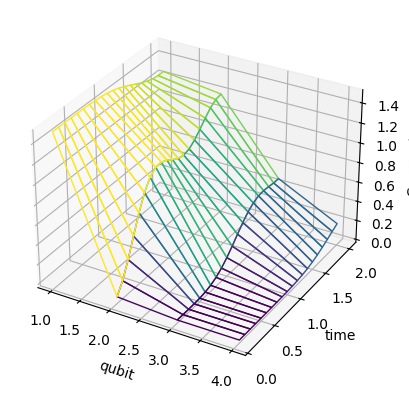

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
norm = plt.Normalize(Cexact.min(), Cexact.max())
colors = cm.viridis(norm(Cexact))
rcount, ccount, _ = colors.shape
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, Cexact, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C_exact(t)')
plt.show()

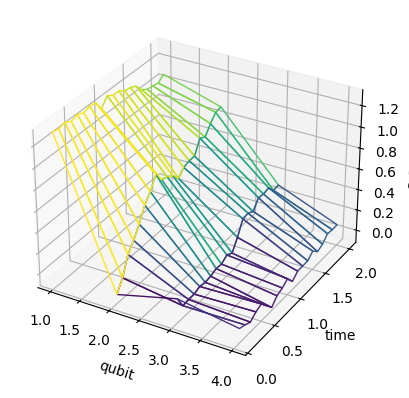

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
norm = plt.Normalize(CF.min(), CF.max())
colors = cm.viridis(norm(CF))
rcount, ccount, _ = colors.shape
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, CF, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C_RTR(t)')
plt.show()

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService

qubits = 4
#Set up variables for Hamiltonian
J = 1
r = 0
h = 0
t = 1

H = XY(qubits, J, r, h)

service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")

job = service.job('cv2wcsb12hg00087adj0')
result = job.result()

print(result[0].data.meas.get_counts())

for j in range(1, 5):
    counts = result[j-1].data
    prob = 0
    fid = 0
    shots = len(counts.c0.array)
    for i in range(0, shots):
        if counts.c0.array[i] == 0:
            prob += 1
            if counts.c1.array[i] == 0:
                fid += 1
    
    fid = fid/prob
    fid = 1/(4*fid)
    prob = prob/shots
    
    CP = 2-2*prob
    CF = 2-2*fid
    
    print("P_EPR: ", CP)
    print("1/(4F_EPR): ", CF)

    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]
    
    Cexact = 0
    U = linalg.expm(-1j*H*t)
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact += 2-2*F.real
    
    Cexact = Cexact/16
    print("Exact: ", Cexact)

{'00': 5082, '11': 4795, '01': 78, '10': 45}


AttributeError: 'DataBin' object has no attribute 'c0'

## Quantum Computation of Operator Spreading

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeOsaka

backend = AerSimulator.from_backend(FakeOsaka())
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# backend = service.least_busy(operational = True, simulator = False)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Set up variables for problem.
qubits = 4
time = 41
tau = 0.05
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
C =  np.zeros((qubits, time))
X = np.zeros((qubits, time))
Y = np.zeros((qubits, time))

#Set up variables for Hamiltonian
J = 1
r = 0.5
h = 1

H = XY(qubits, J, r, h)

spread = np.zeros((qubits, 3))
    
#For each lattice point j, calculates both the OTOC and the Fixed-Node OTOC in time through time increments tau, and stores the result in a matrix. 
for t in range(0, time):
    #Time evolution operator for given time increment t*tau.
    UMatrix = linalg.expm(-1j*H*t*tau)
    
    U = UnitaryGate(UMatrix, label='U')
    for j in range(1, qubits+1):
        spread[j-1][0] = j
        
        OTOC = YKYQuantum(2*(qubits+1), U, j, OTOC_qr)

        isa_circuit = pass_manager.run(OTOC)
        
        shots = 10000
        with Session(backend = backend) as session:
            sampler = Sampler(mode=session)
            result = sampler.run([isa_circuit], shots = shots).result()
        
        counts = result[0].data
        prob = 0
        fid = 0
        for i in range(0, shots):
            if counts.c0.array[i] == 0:
                prob += 1
                if counts.c1.array[i] == 0:
                    fid += 1
        
        fid = fid/prob
        fid = 1/(4*fid)
        prob = prob/shots
        
        C[j-1][t] = 2-2*fid

        if C[j-1][t] > 0.1 and spread[j-1][2] == 0 and t>0:
            spread[j-1][1] = t-1
            spread[j-1][2] = 1
            
        X[j-1][t] = j
        Y[j-1][t] = t


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

#Plots C as a wireframe against j and t (in units of tau).
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_wireframe(X, Y, C)
ax.plot(spread[:, 0], spread[:, 1], zs = 0, color = 'g')
axes = plt.gca()
# axes.set_zlim([0, 4])

1
0
2
0
3
0
4
0
1
1
2
1
3
1
4
1
1
2
2
2
3
2
4
2
1
3
2
3


## Quantum Butterfly Velocity

In [155]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate

backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# backend = service.least_busy(operational = True, simulator = False)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)


# Set up variables for problem.
qubits = 4
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')

#Set up variables for Hamiltonian
J = 1
r = 0
h = 0
H = XY(qubits, J, r, h)

spreadQ =  np.zeros((qubits, 1))

for j in range(1, qubits+1):
    spreadCheck = np.zeros((3, 1))
    t = 0
    while spreadCheck[2] == 0:
        if spreadCheck[1] == 1:
            t += 0.01
        elif spreadCheck[0] == 1:
            t += 0.1
        else:
            t += 1
        
        UMatrix = linalg.expm(-1j*H*t)
        
        U = UnitaryGate(UMatrix, label='U')

        UConj = UnitaryGate(UMatrix.conj())
        
        OTOC = YKYQuantum(2*(qubits+1), U, UConj, j, OTOC_qr)

        isa_circuit = pass_manager.run(OTOC)
        
        shots = 100000
        with Session(backend = backend) as session:
            sampler = Sampler(mode=session)
            result = sampler.run([isa_circuit], shots = shots).result()
        
        counts = result[0].data
        prob = 0
        fid = 0
        for i in range(0, shots):
            if counts.c0.array[i] == 0:
                prob += 1
                if counts.c1.array[i] == 0:
                    fid += 1
        
        fid = fid/prob
        fid = 1/(4*fid)
        prob = prob/shots
        
        C = 2-2*fid

        if C > 0.1:
            if spreadCheck[1] == 1:
                spreadQ[j-1] = t-0.01
                spreadCheck[2] = 1
            elif spreadCheck[0] == 1:
                t -= 0.1
                spreadCheck[1] = 1
            else:
                t -= 1
                spreadCheck[0] = 1

[2.45098039]


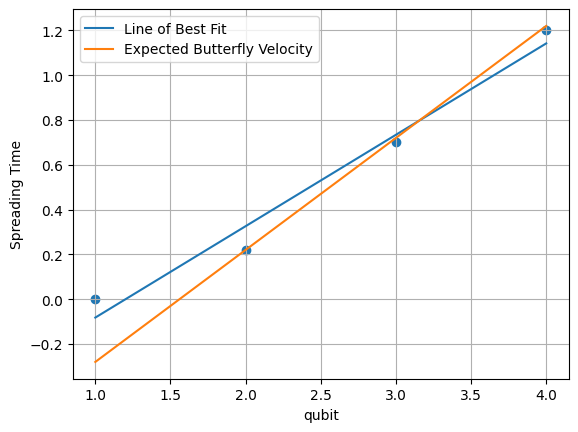

In [159]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(1, len(spreadQ)+1)]
y = spreadQ
ax.scatter(x, y)
ax.grid()
m, b = np.polyfit(x, y, 1)
ax.plot(x, [m*i+b for i in x], label = 'Line of Best Fit')
ax.plot(x, [1/2*(i-1)-0.28 for i in x], label = 'Expected Butterfly Velocity')
ax.set(xlabel = 'qubit', ylabel = 'Spreading Time')
ax.legend()
print(1/m)

## Quantum RTR Butterfly Velocity

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeTorino

backend = AerSimulator.from_backend(FakeTorino())
# backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# real_backend = service.backend("ibm_kyiv")
# backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

import scipy.io

mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit2.mat')
gatesqubit2 = mat_contents['x']

mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit3.mat')
gatesqubit3 = mat_contents['x']

mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit4.mat')
gatesqubit4 = mat_contents['x']

mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit5.mat')
gatesqubit5 = mat_contents['x']

# Set up variables for problem.
qubits = 5
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
m = 8

spreadRTR =  np.zeros((qubits-1, 1))
shots = 10000

with Session(backend = backend) as session:
    sampler = Sampler(mode=session)
    for j in range(2, qubits+1):
        spreadCheck = False
        l = 0
        if j == 2:
            t = 0
            my_tensor = gatesqubit2
        elif j == 3:
            t = 0.8
            my_tensor = gatesqubit3
        elif j == 4:
            t = 1.6
            my_tensor = gatesqubit4
        else:
            t = 2.6
            my_tensor = gatesqubit5
        while spreadCheck == False:
            t += 0.01
            l += 1
            U = QuantumCircuit(qubits)
            UConj = QuantumCircuit(qubits)
            for i in range(0, m):
                if (m-1-i)%2 == 1:
                    for k in range(0, int(qubits/2)):
                        U.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1]), [2*k, 2*k+1])
                        UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1].conj()), [2*k, 2*k+1])
                else:
                    for k in range(0, int((qubits-1)/2)):
                        U.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1]), [2*k+1, 2*k+2])
                        UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1].conj()), [2*k+1, 2*k+2])
            
            OTOC = YKYQuantum(2*(qubits+1), U, UConj, j, OTOC_qr)
    
            isa_circuit = pass_manager.run(OTOC)

            result = sampler.run([isa_circuit], shots = shots).result()
        
            counts = result[0].data
            prob = 0
            fid = 0
            for i in range(0, shots):
                if counts.c0.array[i] == 0:
                    prob += 1
                    if counts.c1.array[i] == 0:
                        fid += 1
            
            fid = fid/prob
            fid = 1/(4*fid)
            prob = prob/shots
            
            C = 2-2*fid

            print(t)
            print(C)
            print("")
    
            if C > 0.1:
                spreadRTR[j-2] = t-0.01
                spreadCheck = True

0.01
0.0675349734684032

0.02
-0.0162729658792653

0.03
0.060123329907502576

0.04
0.07649723200805214

0.05
-0.003955696202531556

0.060000000000000005
0.01131578947368439

0.07
0.11240875912408743

0.81
0.024895020995800765

0.8200000000000001
-0.03022508038585192

0.8300000000000001
-0.02407068860450945

0.8400000000000001
0.04807138744962591

0.8500000000000001
0.05336212214682301

0.8600000000000001
0.041473317865429404

0.8700000000000001
0.02241066020593574

0.8800000000000001
0.03112391930835723

0.8900000000000001
0.0681426106958023

0.9000000000000001
0.06994818652849744

0.9100000000000001
0.02865064695009223

0.9200000000000002
0.07075192421551191

0.9300000000000002
0.11094586555621655

1.61
0.10038932146829826

2.61
0.1135549872122763



[1.20481928]


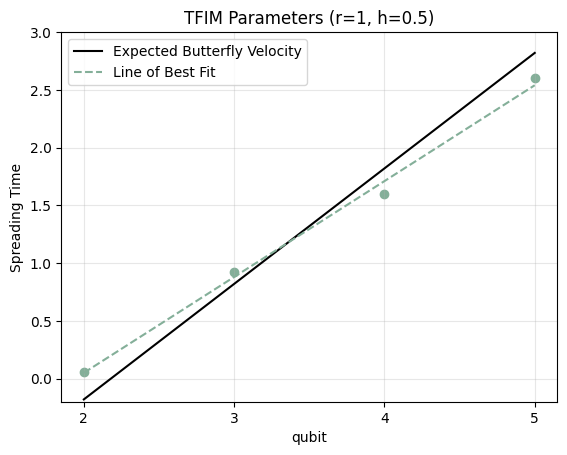

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(2, len(spreadRTR)+2)]
y = spreadRTR
ax.scatter(x, y, color = (133/256, 176/256, 154/256))
ax.grid(alpha = 0.3)
m, b = np.polyfit(x, y, 1)
ax.plot(x, [(i-1)-1.18 for i in x], label = 'Expected Butterfly Velocity', color = 'k')
ax.plot(x, [m*i+b for i in x], '--', label = 'Line of Best Fit', color = (133/256, 176/256, 154/256))
ax.set(xlabel = 'qubit', ylabel = 'Spreading Time', title = 'TFIM Parameters (r=1, h=0.5)')
plt.xticks([2, 3, 4, 5], ['2', '3', '4', '5'])
ax.set_ylim([-0.2, 3])
ax.legend(loc = 2)
print(1/m)

In [5]:
def Pauli(rand, j, n):
    if rand == 0:
        return np.identity(2**n)
    elif rand == 1:
        return GetX(j, n)
    elif rand == 2:
        return GetY(j, n)
    else:
        return GetZ(j, n)

In [11]:
# %matplotlib ipympl
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeTorino
from random import randint

import scipy.io

mat_contents = scipy.io.loadmat('Hamiltonians3Param1.mat')
my_tensor = mat_contents['x']

# backend = AerSimulator.from_backend(FakeTorino())
# backend = AerSimulator()
service = QiskitRuntimeService(channel="ibm_quantum", token="8c2dfffc2ea9f651c6ab08ef76e09bcde67652ec904ea1f5b7f2fbe3a296648712762bce46e8044b50882a2388712dba15f5ce94079f5267769c21b0367764b5")
real_backend = service.backend("ibm_kyiv")
backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Set up variables for problem.
qubits = 3
time = 5
m = 3
target = 3
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
C = np.zeros((2*time+1, 5))
Cexact = np.zeros((10*time+1, 1))
xcoords = np.zeros((10*time+1, 1))

#Set up variables for Hamiltonian
J = 1
r = 0
h = 0

H = XY(qubits, J, r, h)
isa_circuit = []
randPaulis = []

for i in range(0, 18):
    randPaulis.append(randint(0, 3))

shots = 10000
# # with Session(backend = backend) as session:
#     # sampler = Sampler(mode=session)
sampler = Sampler(backend)


for l in range(0, 2*time+1):
    U = QuantumCircuit(qubits)
    UConj = QuantumCircuit(qubits)
    for i in range(0, m):
        if (m-1-i)%2 == 1:
            for j in range(0, int(qubits/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l]), [2*j, 2*j+1])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j, 2*j+1])
        else:
            for j in range(0, int((qubits-1)/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l]), [2*j+1, 2*j+2])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j+1, 2*j+2])
                
    # for i in range(0, m):
    #     if (m-1-i)%2 == 1:
    #         for j in range(0, int(qubits/2)):
    #             if j == 0:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i], 1, 2) @ my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)], 1, 2)), [2*j, 2*j+1])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i], 1, 2).conj() @ my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)], 1, 2).conj()), [2*j, 2*j+1])
    #             else:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i+1], 2, 2) @ Pauli(randPaulis[3*i+2], 1, 2) @ my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)+1], 2, 2) @ Pauli(randPaulis[3*(i-1)+2], 1, 2)), [2*j, 2*j+1])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i+1], 2, 2).conj() @ Pauli(randPaulis[3*i+2], 1, 2).conj() @ my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)+1], 2, 2).conj() @ Pauli(randPaulis[3*(i-1)+2], 1, 2).conj()), [2*j, 2*j+1]) 
    #     else:
    #         for j in range(0, int((qubits-1)/2)):
    #             if j == 0 and i == 0:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i], 2, 2) @ Pauli(randPaulis[3*i+1], 1, 2) @ my_tensor[:, :, m-1-i, l]), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i], 2, 2).conj() @ Pauli(randPaulis[3*i+1], 1, 2).conj() @ my_tensor[:, :, m-1-i, l].conj()), [2*j+1, 2*j+2])
    #             elif i == 0:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i+2], 2, 2) @ my_tensor[:, :, m-1-i, l]), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i+2], 2, 2).conj() @ my_tensor[:, :, m-1-i, l].conj()), [2*j+1, 2*j+2])
    #             elif i == m-1 and j == 0:
    #                 U.append(UnitaryGate(my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)], 2, 2) @ Pauli(randPaulis[3*(i-1)+1], 1, 2)), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)], 2, 2).conj() @ Pauli(randPaulis[3*(i-1)+1], 1, 2).conj()), [2*j+1, 2*j+2])
    #             elif i == m-1:
    #                 U.append(UnitaryGate(my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)+2], 2, 2)), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)+2], 2, 2).conj()), [2*j+1, 2*j+2])                       
    #             elif j == 0:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i], 2, 2) @ Pauli(randPaulis[3*i+1], 1, 2) @ my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)], 2, 2) @ Pauli(randPaulis[3*(i-1)+1], 1, 2)), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i], 2, 2).conj() @ Pauli(randPaulis[3*i+1], 1, 2).conj() @ my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)], 2, 2).conj() @ Pauli(randPaulis[3*(i-1)+1], 1, 2).conj()), [2*j+1, 2*j+2])
    #             else:
    #                 U.append(UnitaryGate(Pauli(randPaulis[3*i+2], 2, 2) @ my_tensor[:, :, m-1-i, l] @ Pauli(randPaulis[3*(i-1)+2], 2, 2)), [2*j+1, 2*j+2])
    #                 UConj.append(UnitaryGate(Pauli(randPaulis[3*i+2], 2, 2).conj() @ my_tensor[:, :, m-1-i, l].conj() @ Pauli(randPaulis[3*(i-1)+2], 2, 2).conj()), [2*j+1, 2*j+2])                       
    
    # UMatrix = linalg.expm(-1j*H*l/2)
    
    # U = UnitaryGate(UMatrix, label='U')

    # UConj = UnitaryGate(UMatrix.conj())

    OTOC = YKYQuantum(2*(qubits+1), U, UConj, target, OTOC_qr)

    isa_circuit.append(pass_manager.run(OTOC))

    print(l, ": done")

result = sampler.run(isa_circuit, shots = shots).result()

# result = service.job('cwd5qrz9r49g008nbtg0').result()

for l in range(0, 2*time+1):
    t = l/2 
    counts = result[l].data
    for j in range(0, 5):
        prob = 0
        fid = 0
        for i in range(j*shots//5, (j+1)*shots//5):
            if counts.c0.array[i] == 0:
                prob += 1
                if counts.c1.array[i] == 0:
                    fid += 1
        
        fid = fid/prob
        fid = 1/(4*fid)
        prob = prob/(shots//5)
        C[l][j] = 2-2*fid

# session.close()

W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
for m in range(0, 10*time+1):
    t = m/10
    V = [np.identity(2**qubits), GetX(target, qubits), GetY(target, qubits), GetZ(target, qubits)]

    U = linalg.expm(-1j*H*t)
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact[m] += 2-2*F.real

    Cexact[m] = Cexact[m]/16
    xcoords[m] = t

0 : done
1 : done
2 : done
3 : done
4 : done
5 : done
6 : done
7 : done
8 : done
9 : done
10 : done


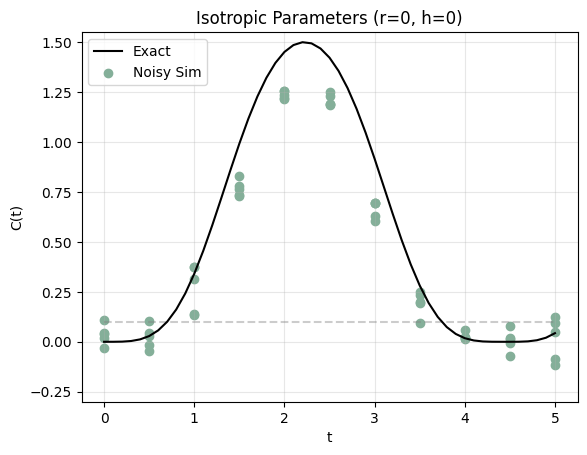

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(xcoords, [0.1 for x in xcoords], '--', color = 'gray', alpha = 0.4)
ax.plot(xcoords, Cexact, color = 'k', label = 'Exact')
for j in range(0, 5):
    if j == 0:
        ax.scatter(xcoords[::5], C[:, j], color = (133/256, 176/256, 154/256), label = 'Noisy Sim')
    else:
        ax.scatter(xcoords[::5], C[:, j], color = (133/256, 176/256, 154/256))
ax.set(xlabel = 't', ylabel = 'C(t)', title = 'Isotropic Parameters (r=0, h=0)')
ax.set_ylim([-0.3, 1.55])
ax.legend(loc = 2)
ax.grid(alpha = 0.3)

In [312]:
m = 8

for l in range(0, 6):
    test_qr = QuantumRegister(qubits)
    test = QuantumCircuit(test_qr)
    
    U = QuantumCircuit(qubits)
    UConj = QuantumCircuit(qubits)
    for i in range(0, m):
        if (m-1-i)%2 == 1:
            for j in range(0, int(qubits/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l], label = str(m-1-i)), [2*j, 2*j+1])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j, 2*j+1])
        else:
            for j in range(0, int((qubits-1)/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l], label = str(m-1-i)), [2*j+1, 2*j+2])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j+1, 2*j+2])
    
    UMatrix = linalg.expm(-1j*H*l/2)
    
    Uexact = UnitaryGate(UMatrix.conj().T, label='U')
    
    UConjexact = UnitaryGate(UMatrix.conj())

    # test.x(0)
    
    test.append(U, test_qr)
    test.append(Uexact, test_qr)

    # test.x(0)
    
    test.measure_all()

    # OTOC1 = YKYQuantum(2*(qubits+1), U, UConj, target, OTOC_qr)
    # OTOC2 = YKYQuantum(2*(qubits+1), Uexact, UConjexact, target, OTOC_qr)
    
    result = sampler.run(pass_manager.run([test]), shots = shots).result()
    print(result[0].data.meas.get_counts())
    # print(result[1].data.c0.get_counts())

     ┌────┐      ┌────┐      ┌────┐      ┌────┐      
q_0: ┤0   ├──────┤0   ├──────┤0   ├──────┤0   ├──────
     │  7 │┌────┐│  5 │┌────┐│  3 │┌────┐│  1 │┌────┐
q_1: ┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├
     ├────┤│  6 │├────┤│  4 │├────┤│  2 │├────┤│  0 │
q_2: ┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├
     │  7 │├────┤│  5 │├────┤│  3 │├────┤│  1 │├────┤
q_3: ┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├
     └────┘│  6 │└────┘│  4 │└────┘│  2 │└────┘│  0 │
q_4: ──────┤1   ├──────┤1   ├──────┤1   ├──────┤1   ├
           └────┘      └────┘      └────┘      └────┘
{'00000': 10000}
     ┌────┐      ┌────┐      ┌────┐      ┌────┐      
q_0: ┤0   ├──────┤0   ├──────┤0   ├──────┤0   ├──────
     │  7 │┌────┐│  5 │┌────┐│  3 │┌────┐│  1 │┌────┐
q_1: ┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├
     ├────┤│  6 │├────┤│  4 │├────┤│  2 │├────┤│  0 │
q_2: ┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├┤0   ├┤1   ├
     │  7 │├────┤│  5 │├────┤│  3 │├────┤│  1 │├────┤
q_3: ┤1   ├

In [294]:
for l in range(0, 7):
    URTR = E(my_tensor[:, :, :, l], 8, 5)
    Uexact = linalg.expm(-1j*H*l/2)
    state = np.zeros((2**qubits, 1))
    state[16] = 1
    print(np.trace(Uexact.conj().T @ URTR).real/32)


1.0
0.9320098335885456
0.7930489397377155
-0.050072812990712146
0.21274958233096872
-0.04825615009626786
-0.07313636498639489


In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService

qubits = 4
#Set up variables for Hamiltonian
J = 1
r = 0
h = 0
t = 0.4

H = XY(qubits, J, r, h)

service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")

job = service.job('cv1np58cn2b00081hp00')
result = job.result()

for j in range(1, 6):
    counts = result[j-1].data
    prob = 0
    fid = 0
    shots = len(counts.c0.array)
    for i in range(0, shots):
        if counts.c0.array[i] == 0:
            prob += 1
            if counts.c1.array[i] == 0:
                fid += 1
    
    fid = fid/prob
    # fid = 1/(4*fid)
    prob = prob/shots
    
    CP = 2-2*prob
    CF = 2-2*fid
    
    print("P_EPR: ", prob)
    print("1/(4F_EPR): ", fid)

    W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    V = [np.identity(2**qubits), GetX(3, qubits), GetY(3, qubits), GetZ(3, qubits)]
    
    Cexact = 0
    U = linalg.expm(-1j*H*j*2/5)
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact += 2-2*F.real
    
    Cexact = Cexact/16
    print("Exact: ", Cexact)

P_EPR:  0.565
1/(4F_EPR):  0.24194690265486726
Exact:  0.012009144696653873
P_EPR:  0.3474
1/(4F_EPR):  0.2651122625215889
Exact:  0.1563639117067699
P_EPR:  0.3743
1/(4F_EPR):  0.2586160833555971
Exact:  0.5456478715240334
P_EPR:  0.3706
1/(4F_EPR):  0.2579600647598489
Exact:  1.0025550211696466
P_EPR:  0.2556
1/(4F_EPR):  0.27034428794992177
Exact:  1.216674783529059
